# COMPARING THE BEHAVIOUR OF LATENT DIRICHLET ALLOCATION AND LATENT SEMANTIC ANALYSIS ON TOPIC MODELING FOR AMAZON BOOK REVIEW


I will be exploring the behaviour of two algorithms for topic modelling. This is Latent Dirichlet Allocation and Latent Semantic Analysis. This is being performed on a dataset that gathers books review from amazon. The goal is to figure out how each technique behaves and models topics from the same dataset. You can find the most up to date dataset here. 

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb
import scipy.stats as stats
import nltk
import string 
import re 
nltk.download('averaged_perceptron_tagger')

from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

import inflect

#Import the wordcloud library
from wordcloud import WordCloud

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

# %matplotlib inline

[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [Errno 11001] getaddrinfo failed>


Loading BokehJS ...

In [2]:
import json
# filename = 'data/Books_5.json'
filename = 'Books_5.json'

chunk_size = 60000

with open(filename, 'r') as file:
    data = []
    for _ in range(chunk_size):
        line = file.readline()
        if not line:
            break  # Stop if the end of the file is reached
        item = json.loads(line)
        data.append(item)

print(data[5])

{'overall': 5.0, 'verified': False, 'reviewTime': '11 3, 2013', 'reviewerID': 'A3H9YD6K9TVKDP', 'asin': '0001713353', 'style': {'Format:': ' Hardcover'}, 'reviewerName': 'James Charnock', 'reviewText': 'Over and over the king has problems.  Fortunately, he has wise men to help him solve his problems.  Unfortunately, his wise men turn one problem into another problem.  So, on top of all his other problems his wise men are a problem too.\n\nWho wants mice all over the place; naughty mice at that?  And so many that they are in your food, even in your beard--you do have a beard?\n\nWell, the wise men have the answer to the problem.  And the king is delighted, but not for long because the problem comes back again and again.  In the end, the king wins ...and the king loses.  How can he both win AND lose?\n\n(Picture Book:  Fanciful Fiction)\n\n<a data-hook="product-link-linked" class="a-link-normal" href="/The-Creative-Teacher-Activities-for-Language-Arts-Grades-4-through-8-and-Up/dp/1604945

Loading Data

In [3]:
df = pd.DataFrame()
df['date'] = [line.get('reviewTime', '') for line in data]
df['text'] = [line.get('reviewText', '') for line in data]
df

,date,text
0,"03 30, 2005","The King, the Mice and the Cheese by Nancy Gur..."
1,"06 20, 2016",The kids loved it!
2,"01 24, 2016",My students (3 & 4 year olds) loved this book!...
3,"07 9, 2015",LOVE IT
4,"01 18, 2015",Great!
...,...,...
59995,"10 6, 2016",They ought to make a movie of this one. It is...
59996,"10 5, 2016",To enter the mind of C S Lewis indeed is an un...
59997,"10 5, 2016",I enjoy non-fiction so reading a book like thi...
59998,"10 4, 2016",One of my all time favorites from CS Lewis. Ad...


Changing Date format

In [4]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')  # Convert to datetime, handle errors gracefully
# Change the date format
df['date'] = df['date'].dt.strftime('%Y-%m-%d')
print(df)

             date                                               text
0      2005-03-30  The King, the Mice and the Cheese by Nancy Gur...
1      2016-06-20                                 The kids loved it!
2      2016-01-24  My students (3 & 4 year olds) loved this book!...
3      2015-07-09                                            LOVE IT
4      2015-01-18                                             Great!
...           ...                                                ...
59995  2016-10-06  They ought to make a movie of this one.  It is...
59996  2016-10-05  To enter the mind of C S Lewis indeed is an un...
59997  2016-10-05  I enjoy non-fiction so reading a book like thi...
59998  2016-10-04  One of my all time favorites from CS Lewis. Ad...
59999  2016-10-04              Excellent imagery.  I love this book!

[60000 rows x 2 columns]


In [5]:
#Converting the sentence into lower case

def text_lowercase(text):
    if not isinstance(text, str):
        return text
    return text.lower()
  

# Remove numbers 
def remove_numbers(text): 
	result = re.sub(r'\d+', '', text) 
	return result 

# import the inflect library 
import inflect 
p = inflect.engine() 

# convert number into words 
def convert_number(text): 
	# split string into list of words 
	temp_str = text.split() 
	# initialise empty list 
	new_string = [] 

	for word in temp_str: 
		# if word is a digit, convert the digit 
		# to numbers and append into the new_string list 
		if word.isdigit(): 
			temp = p.number_to_words(word) 
			new_string.append(temp) 

		# append the word as it is 
		else: 
			new_string.append(word) 

	# join the words of new_string to form a string 
	temp_str = ' '.join(new_string) 
	return temp_str 

# Expand the contraction terms
contractions_dict = {
        "ain't":"is not",
        "aint" : "is not",
        "amn't":"am not",
        "aren't":"are not",
        "arent":"are not,",
        "can't":"cannot",
        "cant":"cannot",
        "cause":"because",
        "couldn't":"could not",
        "couldn't've":"could not have",
        "could've":"could have",
        "daren't":"dare not",
        "daresn't":"dare not",
        "dasn't":"dare not",
        "didn't":"did not",
        "doesn't":"does not",
        "don't":"do not",
        "dont":"do not",
        "didnt":"did not",
        "doesnt":"does not",
        "e'er":"ever",
        "em":"them",
        "everyone's":"everyone is",
        "finna":"fixing to",
        "gimme":"give me",
        "gonna":"going to",
        "gon't":"go not",
        "gotta":"got to",
        "hadn't":"had not",
        "hasn't":"has not",
        "haven't":"have not",
        "he'd":"he would",
        "he'll":"he will",
        "he's":"he is",
        "he've":"he have",
        "how'd":"how would",
        "how'll":"how will",
        "how're":"how are",
        "how's":"how is",
        "I'd":"I would",
        "i'd":"i would",
        "I'll":"I will",
        "i'll":'i will',
        "I'm":"I am",
        "i'm":"i am",
        "I'm'a":"I am about to",
        "I'm'o":"I am going to",
        "isn't":"is not",
        "isnt":"is not",
        "it'd":"it would",
        "it'll":"it will",
        "itll":"it will",
        "it's":"it is",
        "i've":'i have',
        "I've":"I have",
        "kinda":"kind of",
        "let's":"let us",
        "lets":"let us",
        "mayn't":"may not",
        "may've":"may have",
        "mightn't":"might not",
        "might've":"might have",
        "mustn't":"must not",
        "mustn't've":"must not have",
        "must've":"must have",
        "needn't":"need not",
        "ne'er":"never",
        "o'":"of",
        "o'er":"over",
        "ol'":"old",
        "oughtn't":"ought not",
        "shalln't":"shall not",
        "shan't":"shall not",
        "shant":"shall not",
        "she'd":"she would",
        "she'll":"she will",
        "she's":"she is",
        "shouldn't":"should not",
        "shouldnt":"should not",
        "shouldn't've":"should not have",
        "shouldntve":"should not have",
        "should've":"should have",
        "shouldve":"should have",
        "somebody's":"somebody is",
        "someone's":"someone is",
        "something's":"something is",
        "that'd":"that would",
        "that'll":"that will",
        "that're":"that are",
        "that's":"that is",
        "there'd":"there would",
        "there'll":"there will",
        "there're":"there are",
        "there's":"there is",
        "these're":"these are",
        "they'd":"they would",
        "they'll":"they will",
        "they're":"they are",
        "they've":"they have",
        "this's":"this is",
        "those're":"those are",
        "'tis":"it is",
        "'twas":"it was",
        "wanna":"want to",
        "wasn't":"was not",
        "wasnt":"was not",
        "we'd":"we would",
        "we'd've":"we would have",
        "we'll":"we will",
        "we're":"we are",
        "weren't":"were not",
        "we've":"we have",
        "what'd":"what did",
        "what'll":"what will",
        "what're":"what are",
        "what's":"what is",
        "what've":"what have",
        "when's":"when is",
        "where'd":"where did",
        "where're":"where are",
        "where's":"where is",
        "where've":"where have",
        "which's":"which is",
        "who'd":"who would",
        "who'd've":"who would have",
        "who'll":"who will",
        "who're":"who are",
        "who's":"who is",
        "who've":"who have",
        "why'd":"why did",
        "why're":"why are",
        "why's":"why is",
        "won't":"will not",
        "wont":"will not",
        "wouldn't":"would not",
        "wouldnt":"would not",
        "would've":"would have",
        "wouldve":"would have",
        "y'all":"you all",
        "you'd":"you would",
        "you'll":"you will",
        "you're":"you are",
        "you've":"you have",
        "1st":"first",
        "2nd":"second",
        "cus":"because",
        "cuz":"because",
        "u":"you",
        "ff": "fast forward",
        "yrslf":"yourself",
        "hoped":"hope",
        "here's":"here is",
        "romcom":"romantic comedy",
        "rom-com":"romantic comedy"
        }

# remove punctuation 
def remove_punctuation(text): 
	translator = str.maketrans('', '', string.punctuation) 
	return text.translate(translator) 

# Remove Special Characters
def remove_special_characters(text):
    replaced = re.sub("[^a-z ]+.", '', text)
    return(replaced)

# Remove Special Characters
def remove_special_character(text):
    replaced = re.sub(">", '', text)
    return(replaced)

# remove escape characters
def remove_escape_characters(text):
    replaced = re.sub("[\\n\\t]+", '', text)
    return(replaced)

# remove whitespace from text 
def remove_whitespace(text): 
	return " ".join(text.split()) 


from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

# remove stopwords function 
def remove_stopwords(text):
    operators = set(('no'))
    stop = set(stopwords.words('english'))-operators
    nostopwords = [word for word in text.split() if word.lower() not in stop]
    nostopwords = ' '.join(nostopwords)
    return nostopwords

def contraction_expand(text):
    words = text.split()
    expanded_words = [contractions_dict[word] if word in contractions_dict else word for word in words]
    expanded_text = ' '.join(expanded_words)
    return expanded_text


 
# # Lemmatization
# from nltk.stem import WordNetLemmatizer 
# from nltk.tokenize import word_tokenize 
# lemmatizer = WordNetLemmatizer() 
# # lemmatize string 
# def lemmatize_word(text): 
# 	word_tokens = word_tokenize(text) 
# 	# provide context i.e. part-of-speech 
# 	lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in word_tokens] 
# 	return lemmas 


def Preprocessing(input_str):
    input_str = text_lowercase(input_str)
    input_str = convert_number(input_str)
    input_str = remove_numbers(input_str)
    input_str = remove_punctuation(input_str)
    input_str = remove_whitespace(input_str) 
    input_str = remove_escape_characters(input_str)
    input_str = remove_special_characters(input_str)
    input_str = remove_special_character(input_str)
    input_str = remove_stopwords(input_str)
    # input_str = lemmatize_word(input_str)
    return input_str


In [6]:
df['text'] = df['text'].apply(lambda x: Preprocessing(x) if isinstance(x, str) else x)

# Display the updated DataFrame
print(df)

             date                                               text
0      2005-03-30  king mice cheese nancy gurney excellent childr...
1      2016-06-20                                         kids loved
2      2016-01-24  students four year olds loved book definitely ...
3      2015-07-09                                               love
4      2015-01-18                                              great
...           ...                                                ...
59995  2016-10-06  ought make movie one profound stunned days cs ...
59996  2016-10-05  enter mind c lewis indeed unforgettable experi...
59997  2016-10-05  enjoy nonfiction reading book like worthy hard...
59998  2016-10-04  one time favorites cs lewis addresses hard dep...
59999  2016-10-04                        excellent imagery love book

[60000 rows x 2 columns]


In [7]:
df.to_csv(r'data/reviews.csv')

In [8]:
bookreview = pd.read_csv('data/reviews.csv', parse_dates = [0], infer_datetime_format = True)

C:\Users\user\AppData\Local\Temp\ipykernel_15852\3036208609.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  bookreview = pd.read_csv('data/reviews.csv', parse_dates = [0], infer_datetime_format = True)
C:\Users\user\AppData\Local\Temp\ipykernel_15852\3036208609.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  bookreview = pd.read_csv('data/reviews.csv', parse_dates = [0], infer_datetime_format = True)


In [9]:
bookreview=bookreview.drop_duplicates()
bookreview=bookreview.reset_index(drop=True)
bookreview = bookreview.dropna(how='any',axis=0) 

In [10]:
bookreview2 = bookreview['text']
bookreview2.index = bookreview['date'] #This is to publish the dates of the dataset in a way that can be parsed properly for further analysis like timeseries
bookreview2.sample(10) #Random sample of the dataset (10)


date
2017-12-10    good thing dont go back phone get new phone phone
2018-02-02                                     perfect expected
2008-11-24    interesting novel somehow didnt find story com...
2016-06-27                                    great book series
2001-10-05    im big fan tom clancys thrillers unfortunately...
2015-03-02    story seemed drag characters became less inter...
2017-07-27    previously seen movie liked lot book movie hel...
2013-07-21    shakespeare favorite mine kindle edition great...
2017-01-26    seen film read book one times film good nearly...
2017-04-03                               gautamiputra satakarni
Name: text, dtype: object

## Exploratory Data Analysis

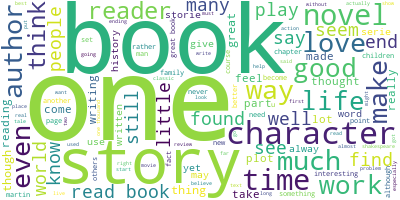

In [11]:
#Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(bookreview['text'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=5, contour_color='grey')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

Now I want to make a list of the most words used across all books review, this will give me some insight into the core vocabulary used in the source dataset. Stop words here will be gotten rid of to prevent any kind of mistakes in accordance to conjunctions, prepositions, etc.

In [12]:
# Defining the helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    This will return a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vec_headlines = count_vectorizer.fit_transform(text_data.values)
    vec_total = np.sum(vec_headlines, axis=0)
    word_indices = np.flip(np.argsort(vec_total)[0,:], 1)
    word_values = np.flip(np.sort(vec_total)[0,:],1)
    
    word_vec = np.zeros((n_top_words, vec_headlines.shape[1]))
    for i in range(n_top_words):
        word_vec[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vec)]

    return (words, word_values[0,:n_top_words].tolist()[0])

count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=bookreview2)

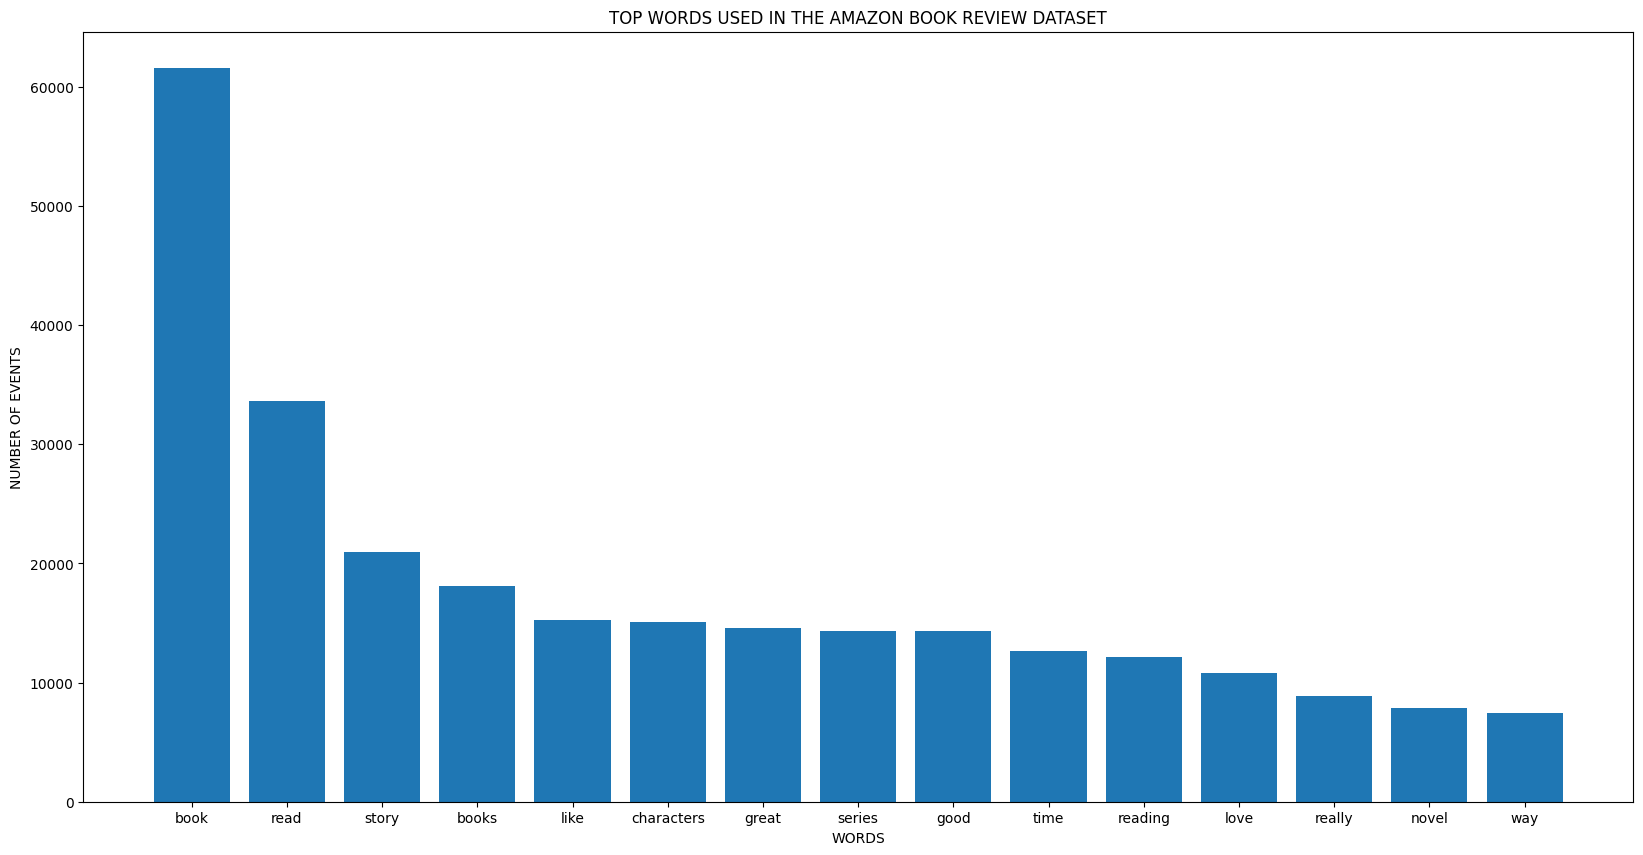

In [13]:
fig, ax = plt.subplots(figsize=(20,10))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='horizontal');
ax.set_title('TOP WORDS USED IN THE AMAZON BOOK REVIEW DATASET');
ax.set_xlabel('WORDS');
ax.set_ylabel('NUMBER OF EVENTS');
plt.show()

I now want to generate a histogram to see the lengths of headlines words, and use part-of-speech tagging to understand the types of words used across the corpus. This requires me to first convert all headline strings to TextBlobs and calling the 'pos_tags' method on each, yielding a list of tagged words for each headline. A complete list of such word tags is available here.

In [ ]:
headlines_tag = [TextBlob(bookreview2[i]).pos_tags for i in range(bookreview2.shape[0])]

C:\Users\user\AppData\Local\Temp\ipykernel_15852\1947602980.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headlines_tag = [TextBlob(bookreview2[i]).pos_tags for i in range(bookreview2.shape[0])]


In [15]:
# Assuming you want to limit to the first 100 items
# limit = 1000
# headlines_tag = [TextBlob(bookreview2[i]).pos_tags for i in range(min(limit, bookreview2.shape[0]))]

C:\Users\user\AppData\Local\Temp\ipykernel_15656\805416844.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headlines_tag = [TextBlob(bookreview2[i]).pos_tags for i in range(min(limit, bookreview2.shape[0]))]


In [16]:
headlines_tag_df = pd.DataFrame({'tags': headlines_tag})

word_counts = [] 
pos_counts =  {}

for headline in headlines_tag_df[u'tags']:
    word_counts.append(len(headline))
    for tag in headline:
        if tag[1] in pos_counts:
            pos_counts[tag[1]] += 1
        else:
            pos_counts[tag[1]] = 1
            
print('THE TOTAL NUMBER OF WORDS: ', np.sum(word_counts))
print('THE MEAN OF TOTAL WORDS PER REVIEW: ', np.mean(word_counts))

THE TOTAL NUMBER OF WORDS:  29083
THE MEAN OF TOTAL WORDS PER REVIEW:  29.083


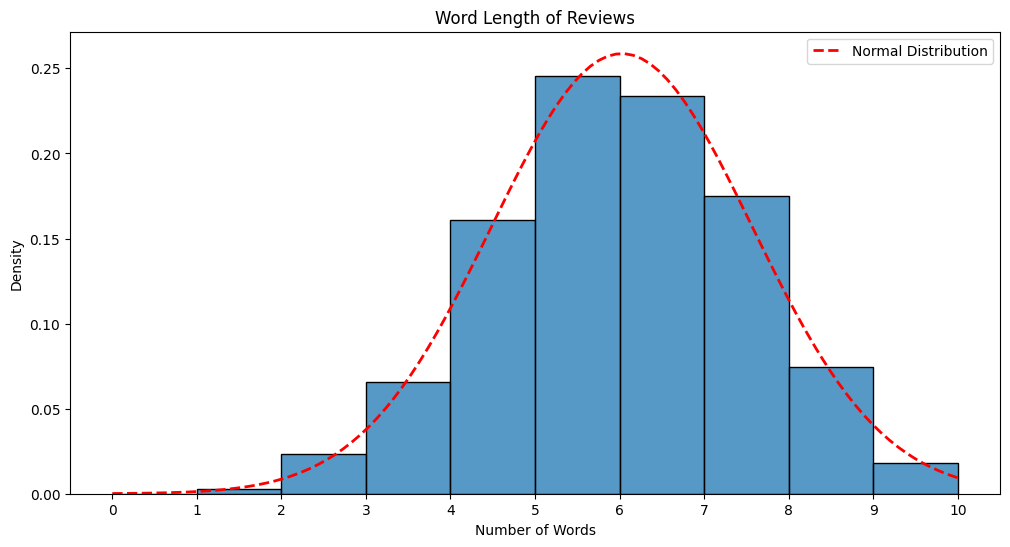

In [17]:
# Generate example data (replace this with your actual data)
word_counts = np.random.normal(loc=6, scale=1.5, size=1000)

# Calculate mean and standard deviation from the data
mean_wc = np.mean(word_counts)
std_wc = np.std(word_counts)

# Generate normal distribution values
y = stats.norm.pdf(np.linspace(0, 10, 100), mean_wc, std_wc)

# Create histogram
fig, ax = plt.subplots(figsize=(12, 6))
sb.histplot(word_counts, bins=range(0, 11), kde=False, ax=ax, stat='density')

# Plot normal distribution curve
ax.plot(np.linspace(0, 10, 100), y, 'r--', linewidth=2, label='Normal Distribution')

ax.set_title('Word Length of Reviews')
ax.set_xticks(range(0, 11))
ax.set_xlabel('Number of Words')
ax.legend()
plt.show()


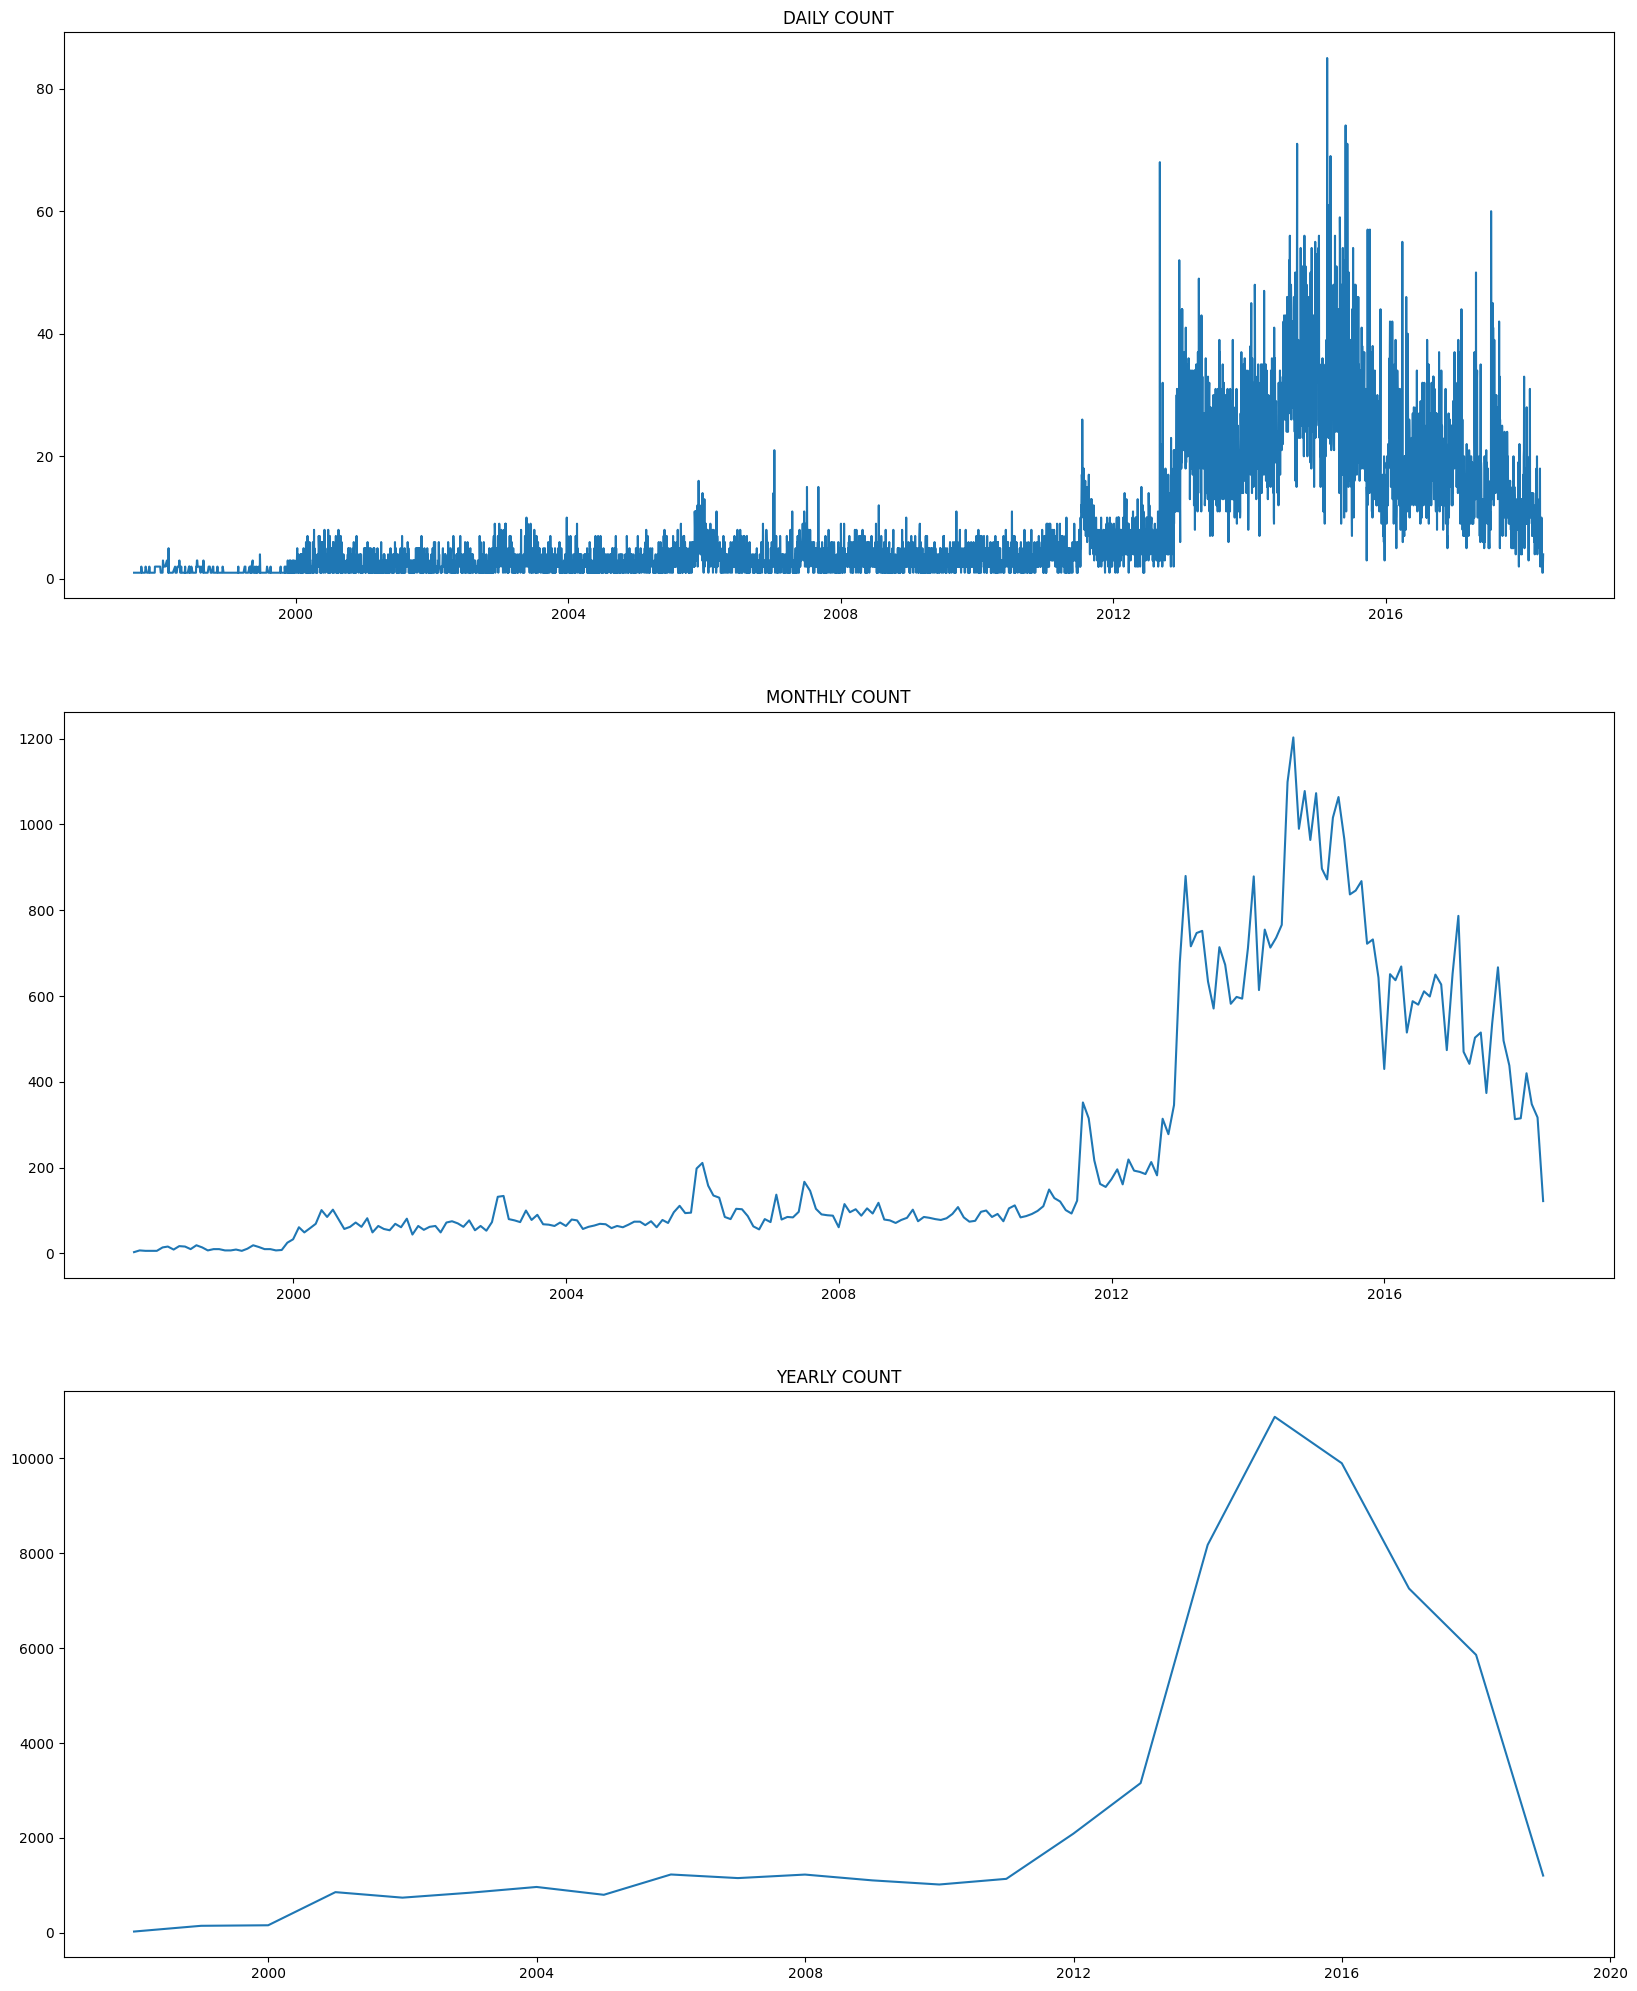

In [18]:
from pandas.plotting import register_matplotlib_converters

# Register the converters
register_matplotlib_converters()

# Assuming 'date' is the name of your column
bookreview['date'] = pd.to_datetime(bookreview['date'])
bookreview.set_index('date', inplace=True)

# Daily count
d_counts = bookreview.groupby(bookreview.index).size()

# Monthly count
m_counts = bookreview.resample('M').size()

# Yearly count
y_counts = bookreview.resample('A').size()

# Plot the counts
fig, ax = plt.subplots(3, figsize=(20, 25))

ax[0].plot(d_counts)
ax[0].set_title('DAILY COUNT')

ax[1].plot(m_counts)
ax[1].set_title('MONTHLY COUNT')

ax[2].plot(y_counts)
ax[2].set_title('YEARLY COUNT')

plt.show()


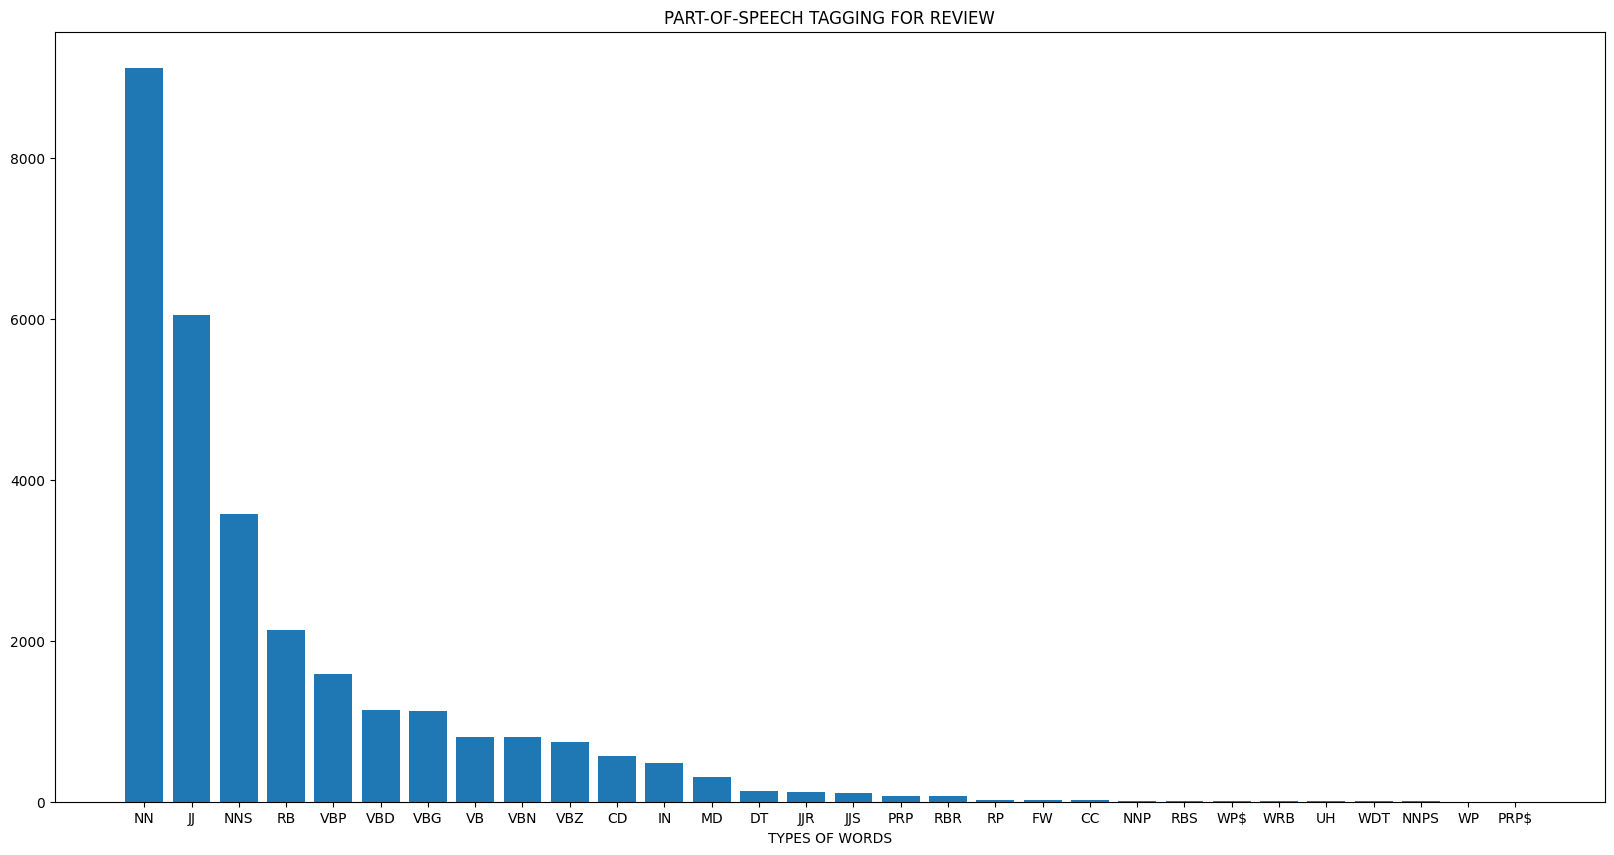

In [19]:

pos_sorted_types = sorted(pos_counts, key=pos_counts.__getitem__, reverse=True)
pos_sorted_counts = sorted(pos_counts.values(), reverse=True)

fig, ax = plt.subplots(figsize=(20,10))
ax.bar(range(len(pos_counts)), pos_sorted_counts);
ax.set_xticks(range(len(pos_counts)));
ax.set_xticklabels(pos_sorted_types);
ax.set_title('PART-OF-SPEECH TAGGING FOR REVIEW');
ax.set_xlabel('TYPES OF WORDS');

The number of books review given by costumer per year, per month and per day can give a better insight into the sample density. I will plot this to show that.

# TOPIC MODELLING

By applying a clustering algorithm to the moview review corpus, I can analyse the topic focus of Amazon book reviews, as well as how it has evolved through time. To do so, we first experiment with a small subsample of the dataset in order to determine which of the two potential clustering algorithms is most appropriate – once this has been ascertained, we then scale up to a larger portion of the available data.

## Preprocessing

The only preprocessing step required in this case is feature construction, where we take the sample of text books review and represent them in some tractable feature space. In practice, this simply means converting each string to a numerical vector. This can be done using the CountVectorizer object from SKLearn, which yields an  n×K  document-term matrix where  K  is the number of distinct words across the  n  books review in our sample (less stop words and with a limit of max_features).

In [20]:
small_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
small_text_sample = bookreview2.sample(n=5000, random_state=0).values

print('REVIEWS BEFORE VECTORIZATION: {}'.format(small_text_sample[123]))

small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

print('REVIEWS AFTER VECTORIZATION: \n{}'.format(small_document_term_matrix[123]))

REVIEWS BEFORE VECTORIZATION: jack ryan president united states finds nation war terrorists released plague country iran march take middle east supported india united states must use limited resources support arab allies heard clancy questioned cia got information book believe rings real headlines war followed truth jack ryan may know much politics sure knows lot strong leader man clancy master wont give much away except say go wolfpack
REVIEWS AFTER VECTORIZATION: 
  (0, 2238)	1
  (0, 17782)	1
  (0, 22901)	1
  (0, 12274)	1
  (0, 21939)	1
  (0, 11993)	1
  (0, 1837)	1
  (0, 8708)	1
  (0, 16490)	1
  (0, 11293)	1
  (0, 10864)	2
  (0, 1498)	1
  (0, 10368)	1
  (0, 22397)	2
  (0, 20057)	1
  (0, 4459)	1
  (0, 11302)	1
  (0, 12470)	1
  (0, 3476)	2
  (0, 9297)	1
  (0, 11537)	1
  (0, 17610)	2
  (0, 15689)	1
  (0, 21708)	2
  (0, 19501)	2
  (0, 7703)	1
  (0, 13475)	1
  (0, 20525)	1
  (0, 16837)	1
  (0, 15181)	1
  (0, 10761)	1
  (0, 12365)	1
  (0, 12792)	1
  (0, 6289)	1
  (0, 20040)	1
  (0, 10266)	

Thus we have our (very high-rank and sparse) training data, small_document_term_matrix, and can now actually implement a clustering algorithm. Our choice will be either Latent Semantic Analysis or Latent Dirichlet Allocation. Both will take our document-term matrix as input and yield an  n×N  topic matrix as output, where  N  is the number of topic categories (which we supply as a parameter). For the moment, we shall take this to be 15.

In [21]:
num_topics = 15

# LATENT SEMANTIC ANALYSIS

Let's start by experimenting with LSA. This is effectively just a truncated singular value decomposition of a (very high-rank and sparse) document-term matrix, with only the  r = num_topics largest singular values preserved.

In [22]:
lsa_model = TruncatedSVD(n_components=num_topics)
lsa_topic_matrix = lsa_model.fit_transform(small_document_term_matrix)

Taking the  argmax  of each moview review in this topic matrix will give the predicted topics of each moview review in the sample. We can then sort these into counts of each topic.

In [23]:
# Defining the helper functions
def get_keys(topic_matrix):
    '''
    This returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    This returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [24]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

However, these topic categories are in and of themselves a little meaningless. In order to better characterise them, it will be helpful to find the most frequent words in each.

In [25]:
import numpy as np

def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    This returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(num_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]

        # Check if temp_vector_sum is an integer
        if isinstance(temp_vector_sum, int):
            temp_vector_sum = np.zeros((1, document_term_matrix.shape[1]))  # Create a zero-filled array
        else:
            # Assuming temp_vector_sum is a matrix
            temp_vector_sum = temp_vector_sum.A  # Convert matrix to ndarray

        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:], 0)
        top_word_indices.append(top_n_word_indices)   
        
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1, document_term_matrix.shape[1]))
            temp_word_vector[:, index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words


In [26]:
top_n_words_lsa = get_top_n_words(15, lsa_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  book read story books characters like time good series great reading really love way life
Topic 2:  ty zzzzzzzzz firecracker finite finland finney finnish fins fiona fiore fireballs firebrands fired firework fireeven
Topic 3:  characters martin plot series new novel previous fantasy world cersei interesting character know time story
Topic 4:  narnia children series lion lewis aslan story witch world wardrobe lucy good edmund caspian time
Topic 5:  read books series reading great good love time best ive characters stories years classic enjoy
Topic 6:  story great read good classic novel characters interesting wonderful love loved best told clancy enjoyed
Topic 7:  caesar antony mccullough octavian cleopatra rome caesarion great son history caesars book roman brutus republic
Topic 8:  shakespeare play caesar plays power julius favorite read story doubt relationships personal brutus text conspired
Topic 9:  chapters years adwd martin year lost time work best jon didnt daenerys h

Thus we have converted our initial small sample of headlines into a list of predicted topic categories, where each category is characterised by its most frequent words. The relative magnitudes of each of these categories can then be easily visualised though use of a bar chart.

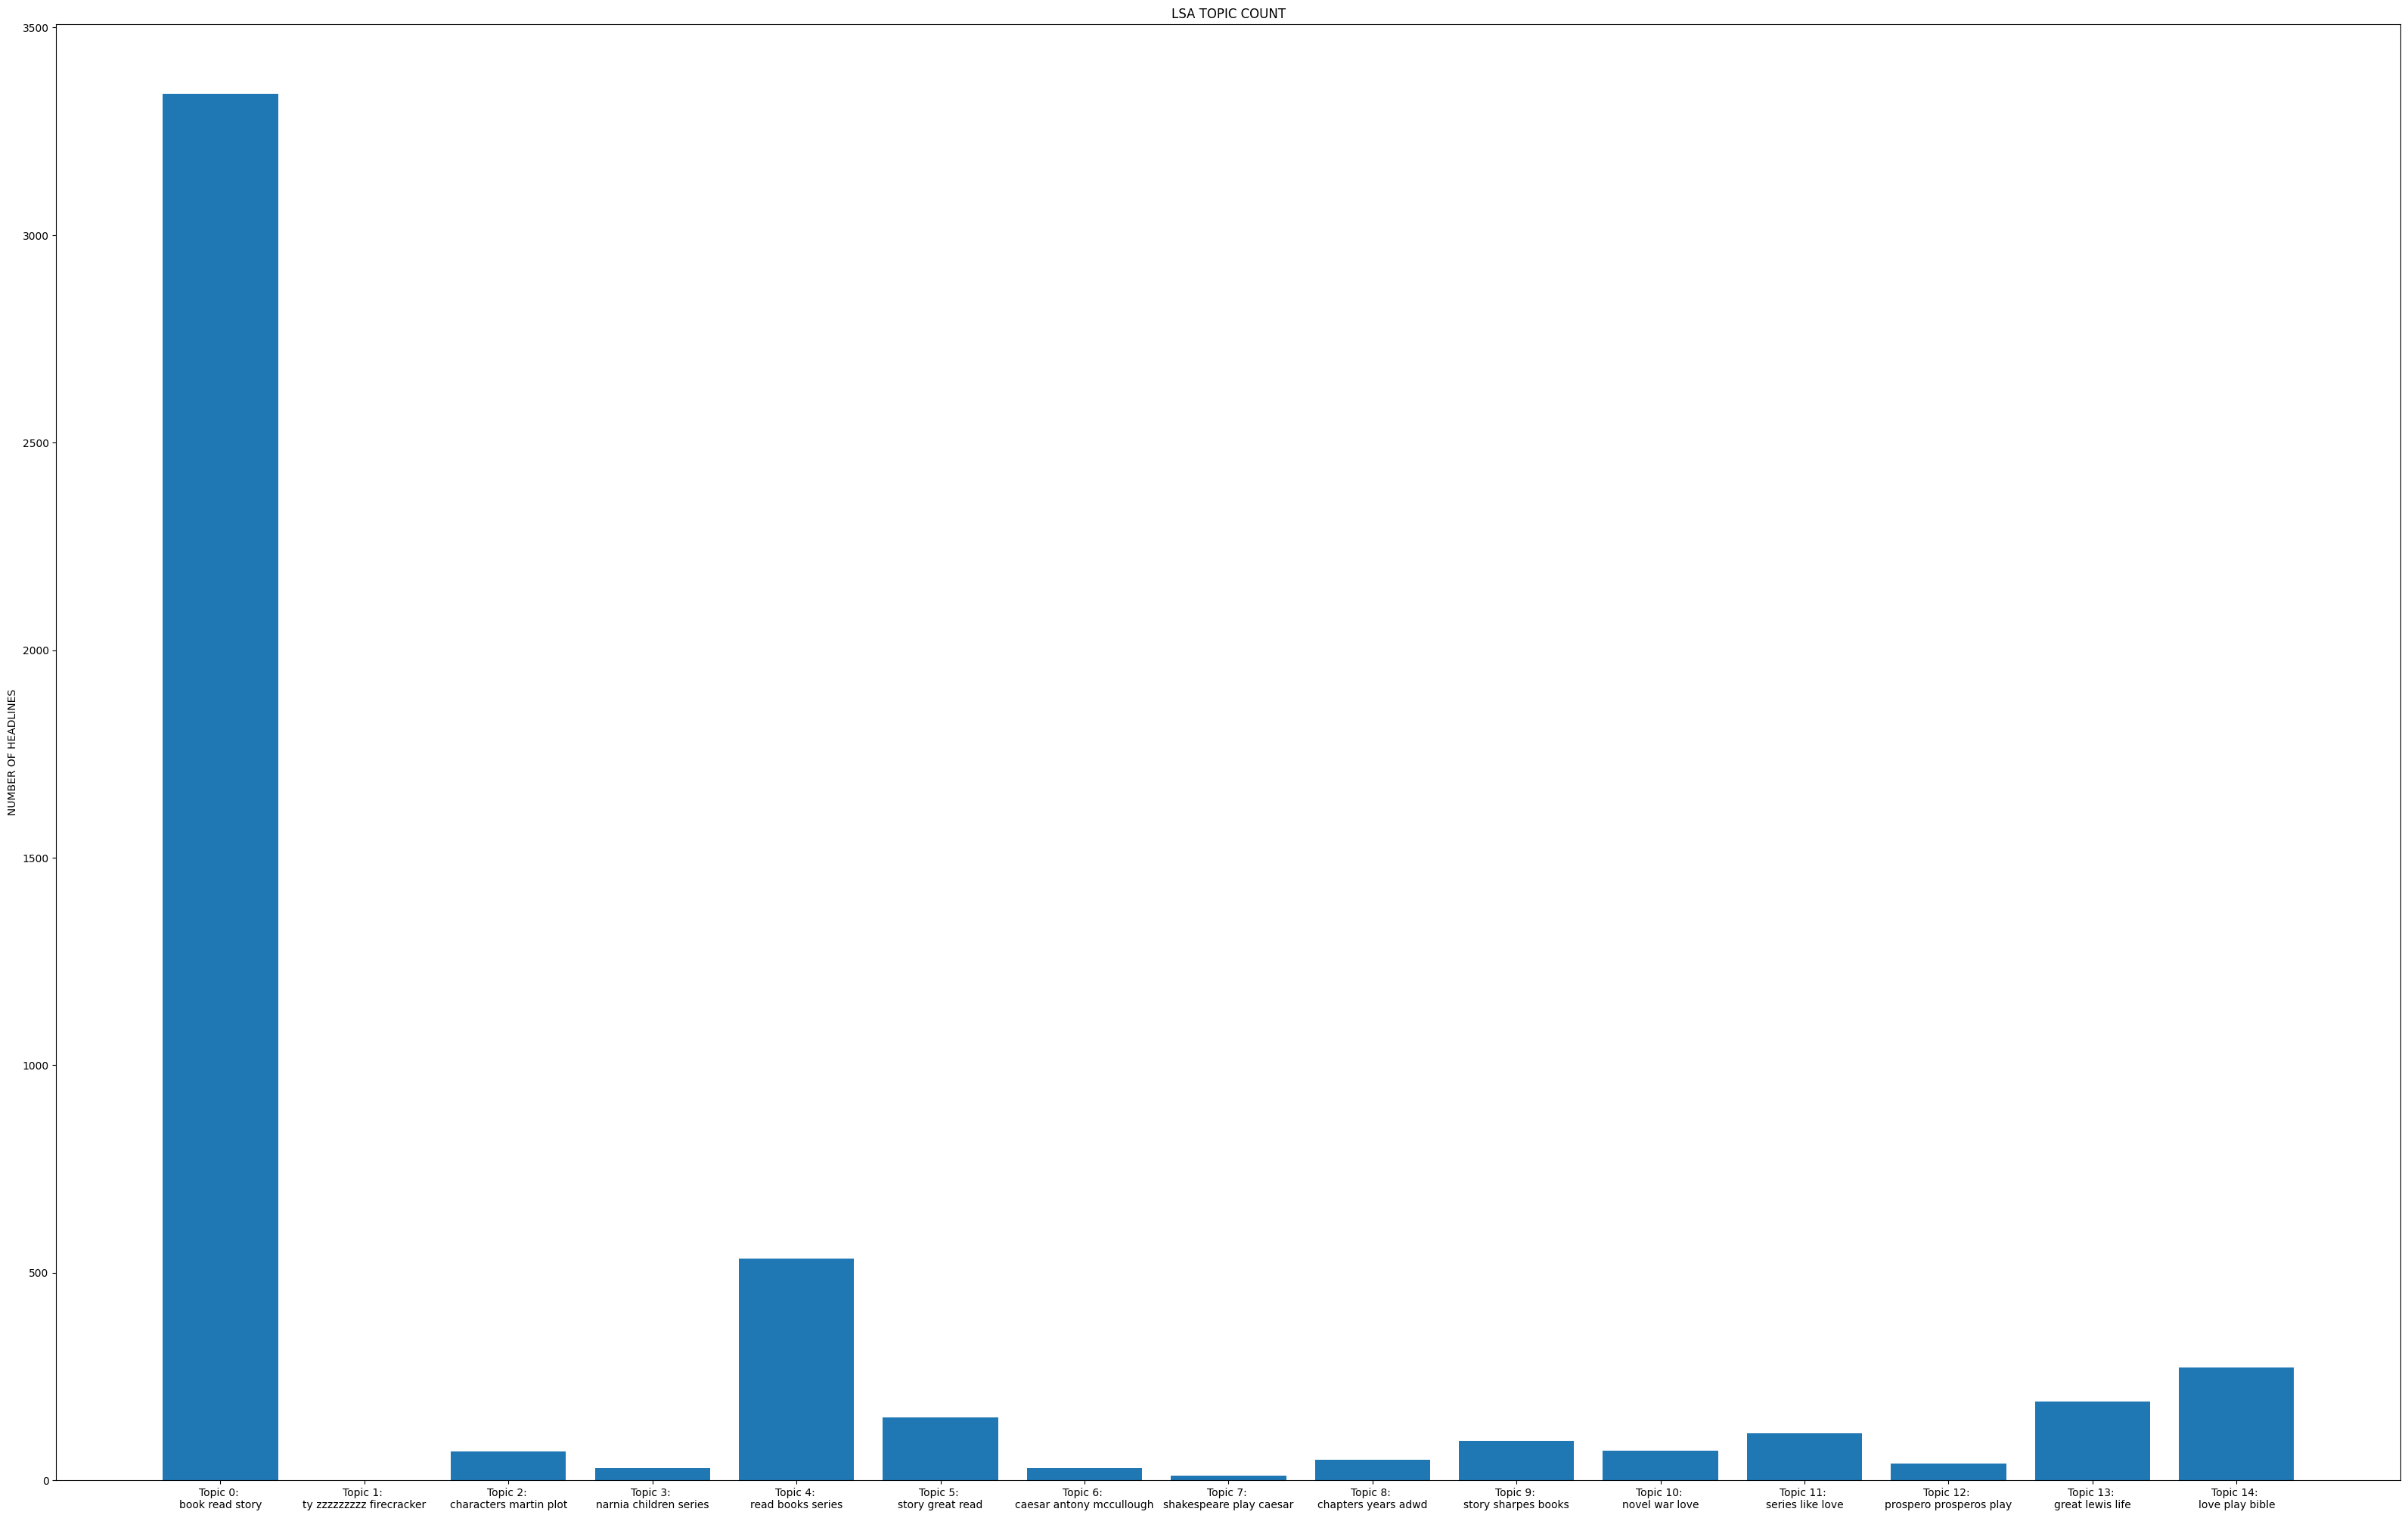

In [27]:
top_3_words = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(40,25))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('NUMBER OF HEADLINES');
ax.set_title('LSA TOPIC COUNT');
plt.show()

However, this does not provide a great point of comparison with other clustering algorithms. In order to properly contrast LSA with LDA we instead use a dimensionality-reduction technique called  t -SNE, which will also serve to better illuminate the success of the clustering process.

In [28]:
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

d:\PythonInstallation\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.006s...
[t-SNE] Computed neighbors for 5000 samples in 0.425s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.045416
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.304482
[t-SNE] KL divergence after 2000 iterations: 0.968982


Now that we have reduced these n_topics-dimensional vectors to two-dimensional representations, we can then plot the clusters using Bokeh. Before doing so however, it will be useful to derive the centroid location of each topic, so as to better contextualise our visualisation.

In [29]:
# Assuming num_topics is defined somewhere in your code before this point


# Defining the helper functions
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    This returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(num_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])
        
        if articles_in_that_topic:
            articles_in_that_topic = np.vstack(articles_in_that_topic)
            mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
            mean_topic_vectors.append(mean_article_in_that_topic)
        else:
            # If there are no articles in that topic, you might want to handle this case
            # Here, I'm adding a placeholder array with zeros
            mean_topic_vectors.append(np.zeros_like(two_dim_vectors[0]))

    return mean_topic_vectors


In [30]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:num_topics]

All that remains is to plot the clustered moview reviews. Also included are the top three words in each cluster, which are placed at the centroid for that topic.

In [32]:
top_3_words_lsa = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer)
lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)

plot = figure(title="t-SNE CLUSTERING OF {} LSA TOPICS".format(num_topics), width=900, height=1000)
plot.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1], color=colormap[lsa_keys])

for t in range(num_topics):
    label = Label(x=lsa_mean_topic_vectors[t][0], y=lsa_mean_topic_vectors[t][1], 
                  text=top_3_words_lsa[t], text_color=colormap[t])
    plot.add_layout(label)
    
show(plot)

Evidently, this is a bit a of a failed result. We have failed to reach any great degree of separation across the topic categories, and it is difficult to tell whether this can be attributed to the LSA decomposition or instead the  t -SNE dimensionality reduction process. Let's move forward and try another clustering technique.

# LATENT DIRICHLET ALLOCATION

We now repeat this process using LDA instead of LSA. LDA is instead a generative probabilistic process, designed with the specific goal of uncovering latent topic structure in text corpora.

In [33]:
lda_model = LatentDirichletAllocation(n_components=num_topics, learning_method='online', 
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(small_document_term_matrix)

Once again, we take the  argmax  of each entry in the topic matrix to obtain the predicted topic category for each moview review. These topic categories can then be characterised by their most frequent words.

In [34]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [35]:
top_n_words_lda = get_top_n_words(50, lda_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

Topic 1:  buy thompson school required teacher exact edition daughters book high demystify fitzchivalry bikers presumably raw circumspect time effort tale readablecontinues outcast braggadocios psychological outlaws nice voice point boozefueled understand experience pal wellreasoned organization edge works satisfy comprehensive subjects sarcastic bright cheats aggression witness gang early inherent nauseating adopts humanity bunch
Topic 2:  book crows ice half feast texas dragons winter recipes chapters storylines series dance imagine events particular bowl mereen volume good characters winds interesting salsa beautiful written cream north food victarion forthcoming jon song tell greyjoy works dream daenerys tempting crackered entire transpiring raised kings untangle photos unusual different muffins photographers
Topic 3:  cat children describes briefly combat whimsy confess read absololutley character tank quieted innocence armored pits morally service wickedness money specifications 

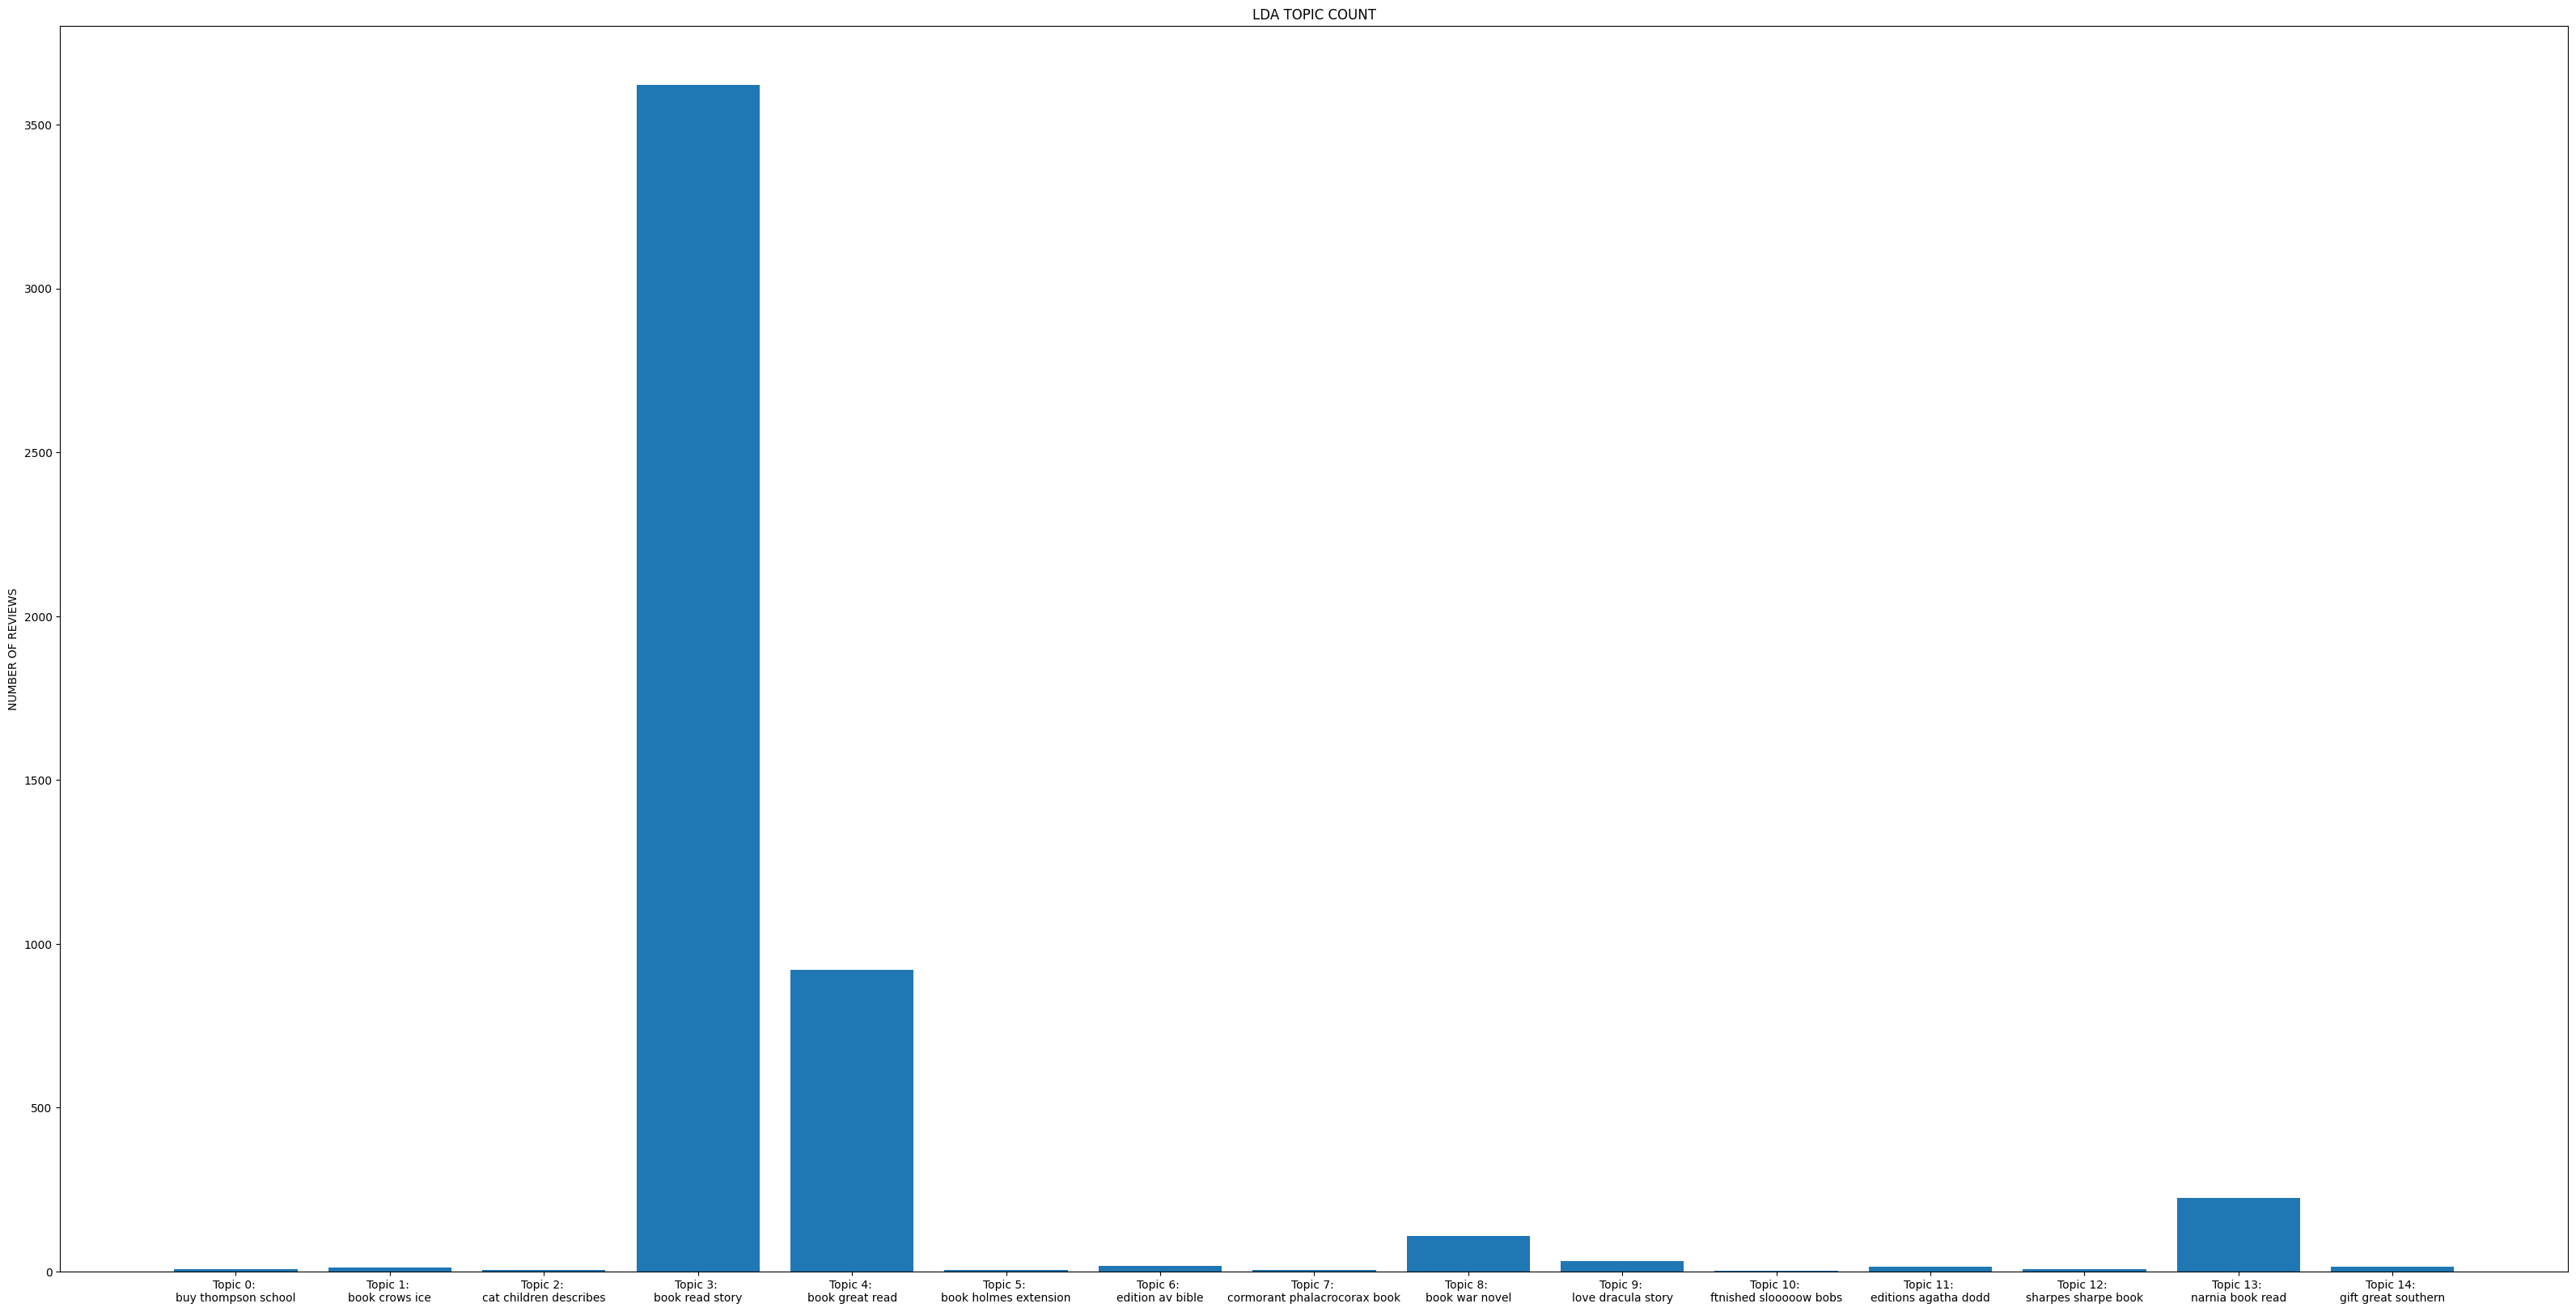

In [36]:
top_3_words = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lda_categories]

fig, ax = plt.subplots(figsize=(40,20))
ax.bar(lda_categories, lda_counts);
ax.set_xticks(lda_categories);
ax.set_xticklabels(labels);
ax.set_title('LDA TOPIC COUNT');
ax.set_ylabel('NUMBER OF REVIEWS');

However, in order to properly compare LDA with LSA, we again take this topic matrix and project it into two dimensions with  t-SNE.

In [37]:
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

d:\PythonInstallation\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.009s...
[t-SNE] Computed neighbors for 5000 samples in 0.203s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.070618
[t-SNE] KL divergence after 2000 iterations: 0.729315


In [38]:
colormap = np.array([
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#c49c94", "#e377c2", "#7f7f7f", "#bcbd22",
    "#f7b6d2", "#dbdb8d", "#17becf", "#9edae5", "#aec7e8", 
    "#ffbb78", "#98df8a", "#ff9896", "#c5b0d5", "#c7c7c7"  ])
colormap = colormap[:num_topics]


In [40]:
top_3_words_lda = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys, tsne_lda_vectors)

plot = figure(title="t-SNE CLUSTERING OF {} LDA TOPICS".format(num_topics), width=900, height=900)
plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])

for t in range(num_topics):
    label = Label(x=lda_mean_topic_vectors[t][0], y=lda_mean_topic_vectors[t][1], 
                  text=top_3_words_lda[t], text_color=colormap[t])
    plot.add_layout(label)

show(plot)

This is a much better result! Controlling for  t -SNE, it would seem that LDA has had much more succcess than LSA in separating out the topic categories. For this reason, LDA appears the more appropriate algorithm when we scale up the clustering process in the next section.

# SCALING UP

Now that we have found an effective clustering algorithm, we can scale it up. We still have to work with a subsample, as it is infeasible to train an LDA model one million observations, but we can significantly increase our scope to  300,000  headlines.

In [41]:
big_sample_size = 50000

big_count_vectorizer = CountVectorizer(stop_words='english', max_features=60000)
big_text_sample = bookreview2.sample(n=big_sample_size, random_state=0).values

big_document_term_matrix = big_count_vectorizer.fit_transform(big_text_sample)

big_lda_model = LatentDirichletAllocation(n_components=num_topics, learning_method='online')
big_lda_model.fit(big_document_term_matrix);

In [42]:
print(bookreview2.index)

Index(['2005-03-30', '2016-06-20', '2016-01-24', '2015-07-09', '2015-01-18',
       '2013-11-03', '2013-10-08', '2013-01-12', '2013-01-02', '2012-12-27',
       ...
       '2016-10-23', '2016-10-18', '2014-03-02', '2016-10-12', '2016-10-10',
       '2016-10-06', '2016-10-05', '2016-10-05', '2016-10-04', '2016-10-04'],
      dtype='object', name='date', length=59923)


In [43]:
num_topics = 15
y_data = []
for year in range(2002, 2018 + 1):
    year_str = str(year)
    matching_indices = [index for index in bookreview2.index if index.startswith(year_str)]
    
    if matching_indices:
        y_data.append(bookreview2.loc[matching_indices].values)
    else:
        # Handle the case where no data is found for the year
        print(f"Data for year {year_str} not found. Matching indices: {matching_indices}")

y_topic_matrices = []
for year in y_data:
    document_term_matrix = big_count_vectorizer.transform(year)
    topic_matrix = big_lda_model.transform(document_term_matrix)
    y_topic_matrices.append(topic_matrix)

y_keys = []
for topic_matrix in y_topic_matrices:
    y_keys.append(get_keys(topic_matrix))

y_counts = []
for keys in y_keys:
    categories, counts = keys_to_counts(keys)  # Include num_topics as an argument
    y_counts.append(counts)

y_topic_counts = pd.DataFrame(y_counts, index=range(2002, 2018 + 1), columns=[f'TOPIC {i + 1}' for i in range(num_topics)])

print(y_topic_counts)


      TOPIC 1  TOPIC 2  TOPIC 3  TOPIC 4  TOPIC 5  TOPIC 6  TOPIC 7  TOPIC 8  \
2002      896      184      237       60       74      103      100       41   
2003      182     1310     1143      131       88      316      100      261   
2004       81      136      724      793       69      291       13       37   
2005      921     1796     1827      177      366      209      115      377   
2006     1753       57      120       75     1322      216      530      101   
2007      113     1549     2186      546      240      160      490      363   
2008      385      175      421     1013     1716       42      165      239   
2009      223      241     1479      776      308      204      288      121   
2010      376     1823      231      755      350       87      228      242   
2011      447      779      742     5876     6234      263      553       26   
2012     1514     1624    20118     1341     1105     3894    10239      678   
2013     6327    96806    17299    11119

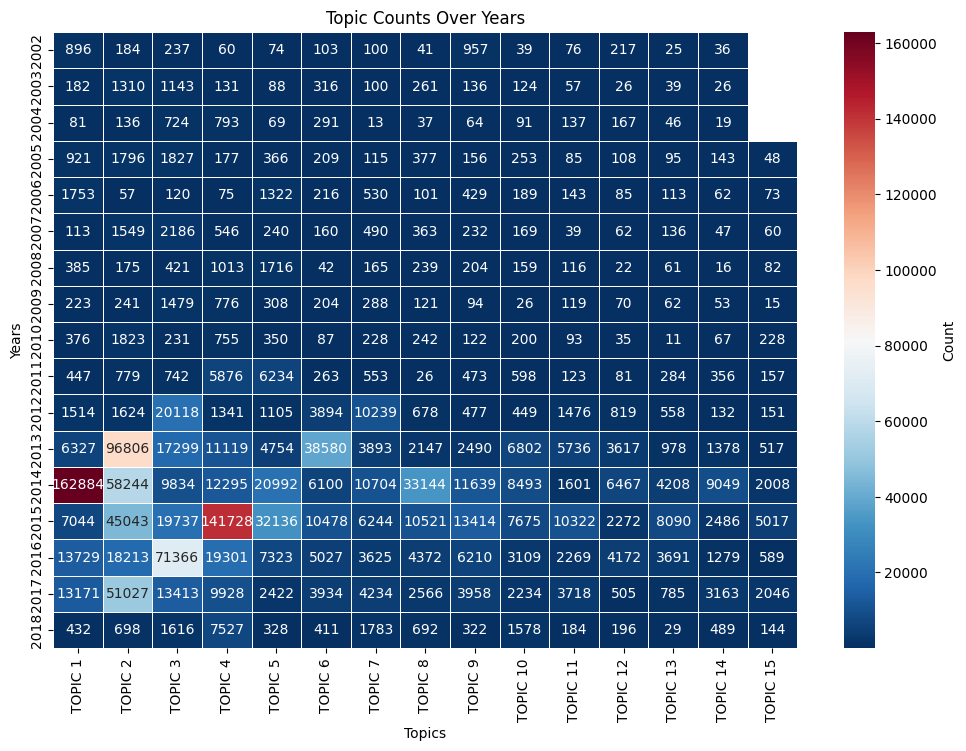

In [44]:
# Plot the heatmap with formatting as floats
plt.figure(figsize=(12, 8))
sb.heatmap(y_topic_counts, cmap="RdBu_r", annot=True, fmt=".0f", linewidths=.5, cbar_kws={"label": "Count"})
plt.title('Topic Counts Over Years')
plt.xlabel('Topics')
plt.ylabel('Years')
plt.show()


We thus have our big topic model. The next step is to pass the entire dataset of one million headlines through this model, and sort by years. This will allow us to develop a table of topic counts per year.

# MEANINGFUL RANDOM REVIEWS BY MARKOV CHAIN

Natural Language Generation is a very important area to be explored in our time. It forms the basis of how a bot would communicate with - not like how literates write books but like how we talk. In this Kernel, I'd like to show you a very simple but powerful Python module that does a similar exercise in (literally) a couple of lines of code.

Module: Markovify

The Py module we use here is markovify.

Descrption of Markovify:

Markovify is a simple, extensible Markov chain generator. Right now, its main use is for building Markov models of large corpora of text, and generating random sentences from that. But, in theory, it could be used for other applications.

Markov chains, named after Andrey Markov, are mathematical systems that hop from one "state" (a situation or set of values) to another. For example, if you made a Markov chain model of a baby's behavior, you might include "playing," "eating", "sleeping," and "crying" as states, which together with other behaviors could form a 'state space': a list of all possible states. In addition, on top of the state space, a Markov chain tells you the probabilitiy of hopping, or "transitioning," from one state to any other state---e.g., the chance that a baby currently playing will fall asleep in the next five minutes without crying first. Read more about how Markov Chain works in this interactive article by Victor Powell

In [45]:
import markovify #Markov Chain Generator

In [46]:
bookreview2.head(10)

date
2005-03-30    king mice cheese nancy gurney excellent childr...
2016-06-20                                           kids loved
2016-01-24    students four year olds loved book definitely ...
2015-07-09                                                 love
2015-01-18                                                great
2013-11-03    king problems fortunately wise men help solve ...
2013-10-08    remember reading parents copy book fell apart ...
2013-01-12    happy book one childrens favorite books please...
2013-01-02    copy tattered worn loved well done plot someti...
2012-12-27    one favorites small child bought copy nephew s...
Name: text, dtype: object

In [47]:
import random
bookreview.text[random.sample(range(100), 10)]


C:\Users\user\AppData\Local\Temp\ipykernel_15656\3841207499.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bookreview.text[random.sample(range(100), 10)]


date
2003-05-10    sinister pig term couple meanings book another...
2013-09-06    great book things go love illustrations rhythm...
2013-10-08    remember reading parents copy book fell apart ...
2017-01-12                      read book years ago enjoyed lot
2004-06-21    great day unique dr seuss book tell looking co...
2017-04-15    plot action fine tony hillerman certainly tell...
2014-05-31    dont know truly explain like book much started...
2012-07-08    volume memory childhood filled lovely poems fa...
2013-06-05    anything great love dr seuss books make great ...
2006-01-16    one books purports something levels actually s...
Name: text, dtype: object

In [48]:
text_model = markovify.NewlineText(bookreview.text, state_size = 2)

In [49]:
for i in range(15):
    print(text_model.make_sentence())

prose haunting poetic wanted start reading great novel featuring would publish book aphorisms realize end lovely prose
textbook far thorough appendices tearouts individual versions ii iii found short offscreen violence discussion bigamy third person multiple characters book fine book contents listed list maps sketches diagrams symbols used people strong willed females facing impossible odds often severest imaginable environmental extremes standards golden rendezvous easily superior though like reading normal bible little hard navigate kindle
confess somewhat mixed feelings admittedly entertained book look makes good deal foamfollower giant lord mhoram bannor bloodguard mr donaldson created great james joyce king english prose plot marsh unspools plot pleasantly leisurely pace final chapters interesting jon snows decision feed wildlings rather simply reacter asidewhere regular professors fairly large typeface perhaps thirteen fourteen fifteen loved every page recommend book everyone son

In [50]:
text_model1 = markovify.NewlineText(bookreview.text, state_size = 3)
text_model2 = markovify.NewlineText(bookreview.text, state_size = 4)

In [51]:
# Print three randomly-generated sentences using the built model
for i in range(10):
    print(text_model1.make_sentence())

classic go wrong dr seuss good family reading time
complete version bible reading times original version dead sea scrolls see little changes added books
mr penick shares lifetime golf wisdom easy read timeless classic must read read one books say wish one teachers inflicted school course wasnt available heyi would happier
love read adhd takes really well written love story guess end chapters
tells us everything need know book good kids liked book lot partially like books military buy book right instead wasting time reading book series like susan coopers dark rising series still somehow managed read chronicles narnia years back really enjoyed like feist definitely like cant wait next ja book
None
wonderful book read years ago still vividly remember haunting story saddistic killer book got hooked game thrones book richly flavoured fantasy history colourful descriptions religionclothing characters book well worth reading
None
None
hard time setting good read good character development mai

In [52]:
# Print three randomly-generated sentences using the built model
for i in range(10):
    temp = text_model2.make_sentence()
    if temp is not None: #escpaing None with this if condition as higher state markov model has generated more Nones
        print(temp)

read negative reviews complaining lack focus main characters loved book much others wish didnt go order series fav


In [53]:
text_model11 = markovify.NewlineText(bookreview.text, state_size = 2)
text_model12 = markovify.NewlineText(bookreview.text, state_size = 2)
model_combo = markovify.combine([ text_model11, text_model12 ], [ 1.5, 1 ])
# Print three randomly-generated sentences using the built model
for i in range(5):
    print(text_model11.make_sentence())

series makes read think people read spattered everywhere thee thou really detracted story im woman leary female writers using male pseudonyms th th book hard put downliterally whenever think baby kochamma god eden uncle chacko margaret kochamma throughout novel boss however character lieutenant schaffer played clint eastwood closely follows found lost story means read voyage dawn treader jadis imposing terrible figure attempts conquer london comical anything lewis good job
boring book absolutely best juvenile novel set fictionalized huntington beach california redevelopment gentrification wiped beach slum erased jagged edges made way defect little black cata
love love series fifth book incredible cash wrote two books become disenchanted storylines two seperate books perhaps one greatest series ever finished hear enough glowing reviews initial installments one voice many gone us plead never forget dr seuss books another great book learned things mary various saints mary sightings etc
sh